# **CONV1d-Mel Spectogram**

In [1]:
#importing libraries

import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
Ravdess = "/content/gdrive/MyDrive/Colab Notebooks/FYP-SER/RAVDESS/"

In [4]:
actors = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in actors:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

,Emotions,Path
0,neutral,/content/gdrive/MyDrive/Colab Notebooks/FYP-SE...
1,neutral,/content/gdrive/MyDrive/Colab Notebooks/FYP-SE...
2,calm,/content/gdrive/MyDrive/Colab Notebooks/FYP-SE...
3,neutral,/content/gdrive/MyDrive/Colab Notebooks/FYP-SE...
4,calm,/content/gdrive/MyDrive/Colab Notebooks/FYP-SE...


In [5]:
data_path = Ravdess_df
data_path.to_csv("/content/gdrive/MyDrive/Colab Notebooks/FYP-SER/data_path.csv",index=False)

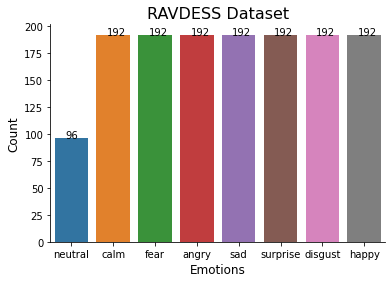

In [6]:
#Data visualisation

plt.title('RAVDESS Dataset', size=16)
ax=sns.countplot(x=data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
plt.show()

In [7]:
#Data Augmentation

def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)


In [8]:
def remove_silent(data):
    data=librosa.effects.trim(data, top_db = 30)[0]
    return data

In [9]:
def extract_features(data):
    
    # Mel spectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=22050, n_mels=50).T, axis=0)
    return mel

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, sr=22050)
    data=remove_silent(data)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching
    stretch_data = stretch(data)
    pitch_stretch_data = pitch(stretch_data, sample_rate)
    res3 = extract_features(stretch_data)
    result = np.vstack((result, res3)) # stacking vertically

    # # data with pitching
    # pitch_data = pitch(data, sample_rate)
    # res4 = extract_features(pitch_data)
    # result = np.vstack((result, res4)) # stacking vertically
    
    return result

In [10]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [11]:
len(X), len(Y), data_path.Path.shape

(4320, 4320, (1440,))

In [12]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('/content/gdrive/MyDrive/Colab Notebooks/FYP-SER/SER2/features_mel_spectogram_50_mel.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,labels
0,0.011117,0.032175,0.012941,0.021906,0.010114,0.028246,0.019351,0.040876,0.020140,0.052697,...,0.000527,0.000322,0.000085,0.000052,0.000085,0.000062,0.000073,0.000167,0.000037,neutral
1,0.011128,0.032201,0.012933,0.021917,0.010105,0.028233,0.019367,0.040898,0.020149,0.052681,...,0.000527,0.000323,0.000086,0.000053,0.000085,0.000063,0.000073,0.000169,0.000038,neutral
2,0.004585,0.016954,0.005307,0.006797,0.003569,0.009583,0.008419,0.011178,0.006444,0.009838,...,0.000231,0.000143,0.000039,0.000022,0.000043,0.000030,0.000032,0.000074,0.000018,neutral
3,0.007575,0.051625,0.033593,0.039366,0.027786,0.037847,0.068940,0.061236,0.078542,0.030551,...,0.001679,0.000615,0.000129,0.000383,0.000255,0.000100,0.000320,0.000318,0.000047,neutral
4,0.007688,0.051647,0.033761,0.039411,0.027828,0.038100,0.069023,0.061128,0.078316,0.030602,...,0.001737,0.000667,0.000177,0.000428,0.000301,0.000146,0.000371,0.000369,0.000094,neutral
